In [ ]:
# Install necessary libraries

from google.colab import files
files.upload()  # kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip -d /content/fashion_product_images


Streaming output truncated to the last 5000 lines.
  inflating: /content/fashion_product_images/myntradataset/images/5813.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58131.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58132.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58133.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58135.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58136.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58137.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58138.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58139.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/5814.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58140.jpg  
  inflating: /content/fashion_product_images/myntradataset/images/58141.jpg  
  inflating: /c

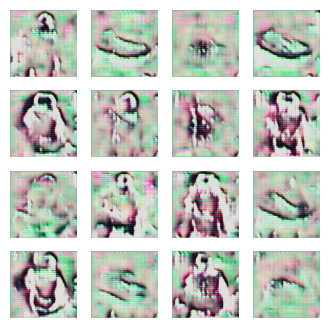

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load the metadata CSV file
df = pd.read_csv('/content/fashion_product_images/styles.csv', on_bad_lines='skip')
df = df[df['id'].apply(lambda x: os.path.exists(f'/content/fashion_product_images/images/{x}.jpg'))]
df['image_path'] = df['id'].apply(lambda x: f"/content/fashion_product_images/images/{x}.jpg")
df = df[['image_path']]
df = df.sample(frac=0.1, random_state=42)

# Load images and preprocess them
def load_images(df, img_size=(256, 256)):
    images = []
    for img_path in tqdm(df['image_path'].values):
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalize the images to [-1, 1]
        images.append(img)
    return np.array(images)

images = load_images(df)

from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential

def build_generator():
    model = Sequential()
    model.add(Dense(16*16*512, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((16, 16, 512)))
    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_discriminator():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    input_layer = Input(shape=(256, 256, 3))
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

discriminator = build_discriminator()
discriminator.summary()
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Training loop
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Generate and save images after each epoch
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # Scale back to [0, 1]
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

seed = tf.random.normal([16, 100])

train(train_dataset, EPOCHS)



# New Section